In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models

#### MNIST digits

In [9]:
class AdaFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, scale=30, margin=0.2, h=1.0):
        super(AdaFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.scale = scale  # Scale parameter for logits
        self.margin = margin  # Base margin
        self.h = h  # Hyperparameter for quality normalization

    def forward(self, embeddings, labels):
        # Normalize feature vectors and class weight vectors
        weight_norm = F.normalize(self.weight, p=2, dim=1)  # Normalize class weights
        feature_norm = torch.norm(embeddings, p=2, dim=1, keepdim=True)  # Compute L2 norm
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings

        # Compute cosine similarity
        cosine_logits = torch.matmul(embeddings, weight_norm.T)

        # Normalize feature norm for quality-adaptive margin
        norm_mean = feature_norm.mean().detach()
        norm_std = feature_norm.std().detach() + 1e-6  # Avoid division by zero
        norm_scaled = (feature_norm - norm_mean) / (norm_std / self.h)
        norm_scaled = torch.clamp(norm_scaled, -1, 1)  # Keep within range
        adaptive_margin = self.margin * norm_scaled.squeeze()

        # Apply adaptive margin only to the correct class
        target_logits = cosine_logits[torch.arange(cosine_logits.shape[0]), labels]
        cosine_logits[torch.arange(cosine_logits.shape[0]), labels] = target_logits - adaptive_margin

        # Scale logits before softmax
        logits = self.scale * cosine_logits

        # Compute softmax cross-entropy loss
        loss = F.cross_entropy(logits, labels)

        return loss


In [10]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        resnet = models.resnet18(pretrained=True)  # Load Pretrained ResNet18
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
        self.fc = nn.Linear(512, embedding_dim)  # Convert 512D ResNet features to 128D

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = torch.flatten(x, 1)  # Flatten
        x = self.fc(x)  # Get 128D embeddings
        return x


In [11]:
# Load MNIST dataset (ResNet needs 224x224 images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet needs larger images
    transforms.Grayscale(3),  # Convert to 3 channels (RGB)
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
# Initialize Model and Optimizer PROPERLY
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFeatureExtractor().to(device)  # Move to device FIRST
criterion = AdaFaceLoss(in_features=128, out_features=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


 Epoch [1/10], Avg Loss: 0.0799
 Epoch [2/10], Avg Loss: 0.1853
 Epoch [3/10], Avg Loss: 0.1149
 Epoch [4/10], Avg Loss: 0.1068
 Epoch [5/10], Avg Loss: 0.0842
 Epoch [6/10], Avg Loss: 0.0681
 Epoch [7/10], Avg Loss: 0.0795
 Epoch [8/10], Avg Loss: 0.0742
 Epoch [9/10], Avg Loss: 0.0511
 Epoch [10/10], Avg Loss: 0.0463


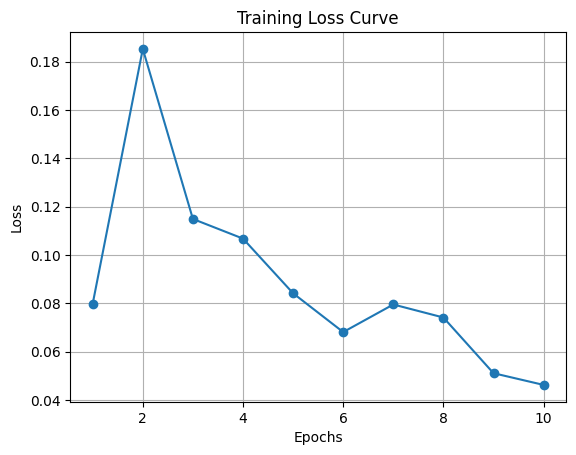

In [15]:
# Train the Model
num_epochs = 10
loss_values = []  # Store loss values for visualization

for epoch in range(num_epochs):
    running_loss = 0.0  # Accumulate loss for averaging

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  #  Correct device assignment

        # Forward pass
        embeddings = model(images)
        loss = criterion(embeddings, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()  # Accumulate loss

    # Compute Average Loss for the Epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)  # Store for visualization

    print(f" Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

# Plot Training Loss Curve After Training
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.show()


In [18]:
# Load Test Dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Compute logits using cosine similarity
            embeddings = model(images)
            weight_norm = F.normalize(criterion.weight, p=2, dim=1)
            logits = torch.matmul(F.normalize(embeddings, p=2, dim=1), weight_norm.T)
            predictions = torch.argmax(logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f" Test Accuracy: {accuracy:.2f}%")

#  Compute Accuracy
evaluate_accuracy(model, test_loader)


 Test Accuracy: 97.48%


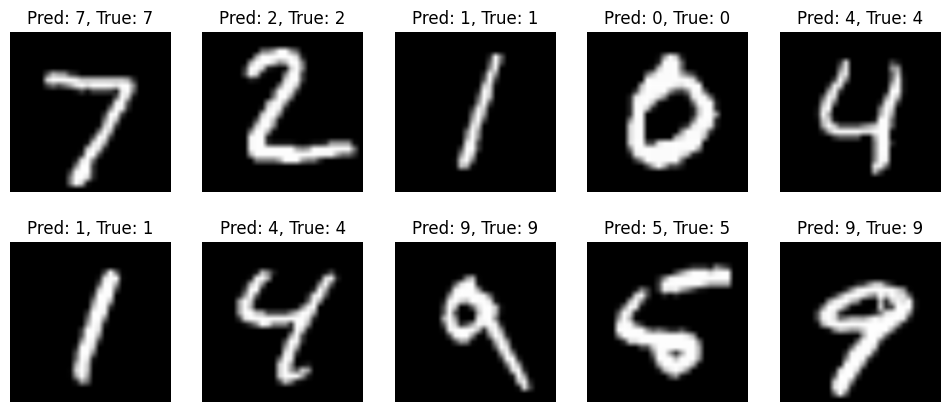

In [19]:
import numpy as np

def show_predictions(model, test_loader, num_images=10):
    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # 2 Rows x 5 Columns
    axes = axes.ravel()  # Flatten axes array

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            embeddings = model(images)
            weight_norm = F.normalize(criterion.weight, p=2, dim=1)
            logits = torch.matmul(F.normalize(embeddings, p=2, dim=1), weight_norm.T)
            predictions = torch.argmax(logits, dim=1)

            for i in range(num_images):
                img = images[i].cpu().permute(1, 2, 0).numpy()  # Convert tensor to numpy
                img = np.squeeze(img)  # Remove channel dimension

                axes[images_shown].imshow(img, cmap='gray')
                axes[images_shown].set_title(f"Pred: {predictions[i].item()}, True: {labels[i].item()}")
                axes[images_shown].axis('off')

                images_shown += 1
                if images_shown >= num_images:
                    plt.show()
                    return

# Show predictions
show_predictions(model, test_loader)


#### CIFAR10

In [30]:
# Define AdaFace Loss
class AdaFaceLoss_1(nn.Module):
    def __init__(self, in_features, out_features, scale=10, margin=0.1, h=1.5):
        super(AdaFaceLoss_1, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.scale = scale
        self.margin = margin
        self.h = h

    def forward(self, embeddings, labels):
        weight_norm = F.normalize(self.weight, p=2, dim=1)
        feature_norm = torch.norm(embeddings, p=2, dim=1, keepdim=True) + 1e-4
        embeddings = F.normalize(embeddings, p=2, dim=1)

        logits = torch.matmul(embeddings, weight_norm.T)

        norm_mean = feature_norm.mean().detach()
        norm_std = feature_norm.std().detach() + 1e-6
        norm_scaled = (feature_norm - norm_mean) / (norm_std / self.h)
        norm_scaled = torch.clamp(norm_scaled, -1, 1)
        adaptive_margin = self.margin * norm_scaled.squeeze()

        target_logits = logits[torch.arange(logits.shape[0]), labels]
        logits[torch.arange(logits.shape[0]), labels] = target_logits - adaptive_margin

        logits = self.scale * logits
        loss = F.cross_entropy(logits, labels)
        return loss


In [31]:
# Define Feature Extractor (ResNet for CIFAR-10)
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
        self.fc = nn.Linear(512, embedding_dim)  # Convert 512D ResNet features to 128D

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)  # 128D embedding
        return x

In [32]:
# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize CIFAR-10
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
# Initialize Model and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetFeatureExtractor().to(device)
criterion = AdaFaceLoss_1(in_features=128, out_features=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Train Model
num_epochs = 10
loss_values = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        embeddings = model(images)
        loss = criterion(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f" Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}")

 Epoch [1/10], Avg Loss: 1.6465
 Epoch [2/10], Avg Loss: 1.1645
 Epoch [3/10], Avg Loss: 0.8925
 Epoch [4/10], Avg Loss: 0.7710
 Epoch [5/10], Avg Loss: 0.7181
 Epoch [6/10], Avg Loss: 0.6351
 Epoch [7/10], Avg Loss: 0.5531
 Epoch [8/10], Avg Loss: 0.4930
 Epoch [9/10], Avg Loss: 0.4367
 Epoch [10/10], Avg Loss: 0.3876


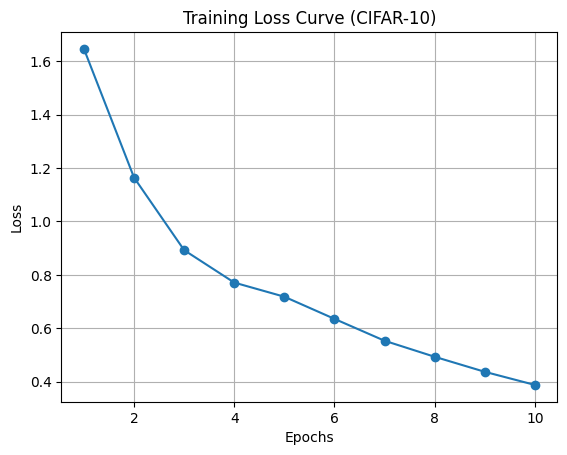

In [36]:
# Plot Training Loss Curve
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve (CIFAR-10)')
plt.grid()
plt.show()

In [38]:
# Compute Accuracy
def evaluate_accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            embeddings = model(images)
            weight_norm = F.normalize(criterion.weight, p=2, dim=1)
            logits = torch.matmul(F.normalize(embeddings, p=2, dim=1), weight_norm.T)
            predictions = torch.argmax(logits, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f" Test Accuracy on CIFAR-10: {accuracy:.2f}%")

evaluate_accuracy(model, test_loader)


 Test Accuracy on CIFAR-10: 75.67%


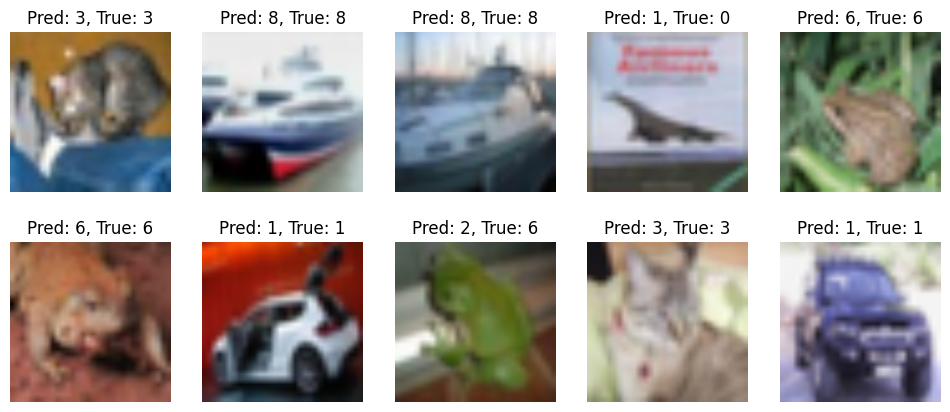

In [39]:
# Show Sample Predictions
def show_predictions(model, test_loader, num_images=10):
    model.eval()
    images_shown = 0

    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.ravel()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            embeddings = model(images)
            weight_norm = F.normalize(criterion.weight, p=2, dim=1)
            logits = torch.matmul(F.normalize(embeddings, p=2, dim=1), weight_norm.T)
            predictions = torch.argmax(logits, dim=1)

            for i in range(num_images):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5  # Denormalize CIFAR-10

                axes[images_shown].imshow(img)
                axes[images_shown].set_title(f"Pred: {predictions[i].item()}, True: {labels[i].item()}")
                axes[images_shown].axis('off')

                images_shown += 1
                if images_shown >= num_images:
                    plt.show()
                    return

show_predictions(model, test_loader)
